## Import modules

In [1]:
import struct
import numpy as np
from array import array
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm # Needed for showing good contour colors
from sklearn.mixture import GaussianMixture

## Excel functions

In [2]:
def readExcelSheet1(excelfile):
    from pandas import read_excel
    return (read_excel(excelfile)).values

def readExcelRange(excelfile,sheetname="Sheet1",startrow=1,endrow=1,startcol=1,endcol=1):
    from pandas import read_excel
    values=(read_excel(excelfile, sheetname,header=None)).values;
    return values[startrow-1:endrow,startcol-1:endcol]

def readExcel(excelfile,**args):
    if args:
        data=readExcelRange(excelfile,**args)
    else:
        data=readExcelSheet1(excelfile)
    if data.shape==(1,1):
        return data[0,0]
    elif (data.shape)[0]==1:
        return data[0]
    else:
        return data

def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()

def getSheetNames(excelfile):
    from pandas import ExcelFile
    return (ExcelFile(excelfile)).sheet_names

## Import data

In [3]:
# MNIST directory
mnist_data_dir=r'C:\Users\Shahnewaz\Documents\ds_projects\Principal_Component_Analysis_MNIST\data'

In [4]:
# Function to parse and read MNIST data
# Usage examples:
# X_train, y_train = load_mnist() #Loads ALL digits of training data
# X_test, y_test = load_mnist(dataset="testing",digits=[1,2,7])
#
def load_mnist(dataset="training", digits=range(10), mnist_data_dir=mnist_data_dir):

    #Check training/testing specification. Must be "training" (default) or "testing"
    if dataset == "training":
        fname_digits = mnist_data_dir + '\\' + 'train-images.idx3-ubyte'
        fname_labels = mnist_data_dir + '\\' + 'train-labels.idx1-ubyte'
    elif dataset == "testing":
        fname_digits = mnist_data_dir + '\\' + 't10k-images.idx3-ubyte'
        fname_labels = mnist_data_dir + '\\' + 't10k-labels.idx1-ubyte'
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
        
        
    #Import digits data
    digitsfileobject = open(fname_digits, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", digitsfileobject.read(16))
    digitsdata = array("B", digitsfileobject.read())
    digitsfileobject.close()

    #Import label data
    labelsfileobject = open(fname_labels, 'rb')
    magic_nr, size = struct.unpack(">II", labelsfileobject.read(8))
    labelsdata=array("B",labelsfileobject.read())
    labelsfileobject.close()
    
    #Find indices of selected digits
    indices=[k for k in range(size) if labelsdata[k] in digits]
    N=len(indices)
    
    #Create empty arrays for X and y
    X = np.zeros((N, rows*cols), dtype=np.uint8)
    y = np.zeros((N, ), dtype=np.uint8)
    
    #Fill X from digitsdata
    #Fill y from labelsdata
    for i in range(N):
        X[i] = digitsdata[indices[i]*rows*cols:(indices[i]+1)*rows*cols]
        y[i] = labelsdata[indices[i]]
    
    return X,y

In [11]:
# Function to reformat feature vectors and show them as images
def vectortoimg(*args,width=28,size=1,show=True):
    """
    Example: vectortoimg(random.random(784)) or vectortoimg(random.random(784),arange(784))
    
    """
    n=len(args)
    fig = plt.figure()
    for i,arg in enumerate(args):
        plt.subplot(1,n,i+1)
        plt.imshow(arg.reshape(width, width),interpolation='None', cmap='gray')
        plt.axis('off')
    fig.tight_layout(pad=0)
    fig.set_size_inches(w=n*size,h=size)
    if show:
        plt.show()

## Load data

In [6]:
# Only loading digit 7
digits=[7]

In [7]:
X_train, y_train = load_mnist(dataset="training", digits=digits)

In [8]:
print("Checking shape of matrix:", X_train.shape)
print("Checking min/max values:", (np.amin(X_train), np.amax(X_train)))
print("Checking unique labels in y:", list(np.unique(y_train)))

Checking shape of matrix: (6265, 784)
Checking min/max values: (0, 255)
Checking unique labels in y: [7]


## Display images

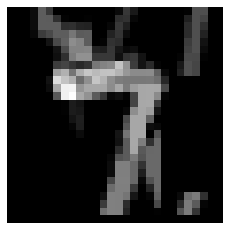

In [15]:
# Viewing one row of X_train as image
vectortoimg(X_train[6100], width=28, size=3)

In [17]:
# Label of image above
y_train[6100]

7

C:\Users\Shahnewaz\AppData\Local\Temp\ipykernel_23680\3494388748.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))


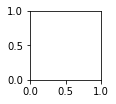

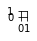

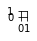

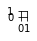

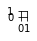

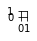

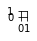

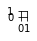

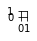

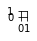

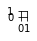

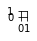

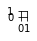

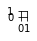

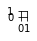

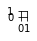

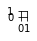

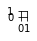

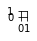

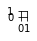

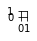

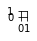

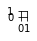

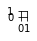

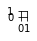

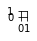

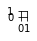

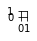

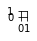

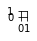

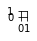

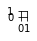

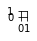

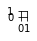

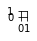

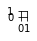

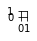

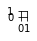

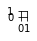

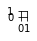

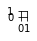

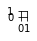

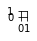

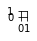

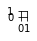

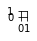

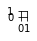

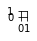

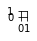

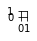

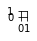

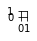

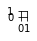

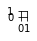

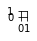

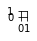

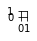

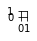

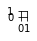

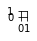

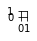

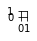

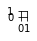

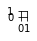

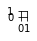

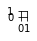

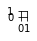

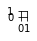

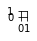

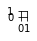

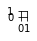

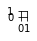

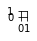

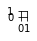

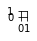

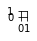

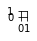

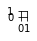

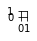

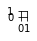

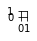

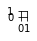

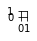

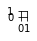

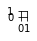

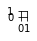

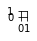

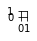

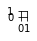

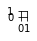

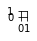

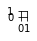

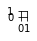

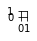

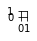

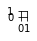

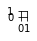

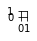

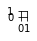

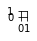

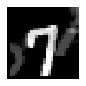

In [19]:
# Show multiple randomly selected rows of X_train as images
fig = plt.figure(figsize=(15,15))
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X_train[np.random.randint(len(y_train))],show=False)
plt.show()

## PCA setup

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
class XZCVPR(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components='all'):
        self.n_components = n_components
        
    def fit(self, X, y=None):
        self.n_components_ = self.n_components
        self.mean_ = np.mean(X, axis=0)
        Z = X-self.mean_
        C = np.cov(Z, rowvar=False)
        [λo,Vo] = np.linalg.eigh(C)
        λF = np.flipud(λo)
        VTF = np.flipud(Vo.T)
        
        if self.n_components == 'all':
            self.eigenvalues_ = λF
            self.eigenvectors_ = VTF
        else:
            self.eigenvalues_ = λF[:self.n_components_]
            self.eigenvectors_ = VTF[:self.n_components_]
            
        return self
    
    def transform(self, X, y=None):
        
        Z = X - self.mean_
        P = np.dot(Z, self.eigenvectors_.T)
        
        return P
    
    def inv_transform(self, P, y=None):
        R = np.dot(P, self.eigenvectors_)
        Xrec = R + self.mean_
        return Xrec

## XVCVP run

In [44]:
pca = XZCVPR(n_components = 50)

In [45]:
pca.fit(X_train)

XZCVPR(n_components=50)

In [46]:
P_train = pca.transform(X_train)

In [47]:
P_train.shape

(6265, 50)

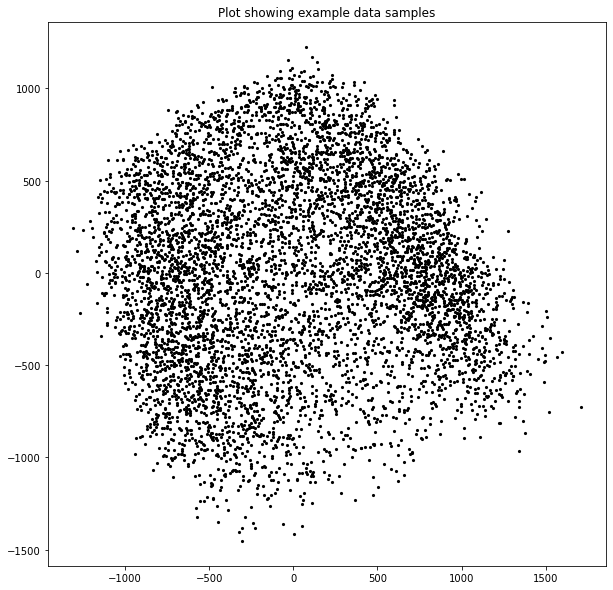

In [48]:
fig = plt.figure(figsize=(10,10))
ax=plt.gca() # Get current axis
ax.set_title('Plot showing example data samples')
plt.scatter(P_train[:, 0], P_train[:, 1], s=10, linewidths=0, facecolors='black', marker="o")
plt.show()

## Gaussian mixture

In [49]:
estimator = GaussianMixture(n_components=11, covariance_type='full')

estimator.fit(P_train)

GaussianMixture(n_components=11)

In [50]:
[a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10] = estimator.weights_; print(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, sep='\n\n')

0.1046784965494979

0.10256268453450929

0.10985572846671736

0.07805476329355641

0.056140493028118986

0.07711281829703055

0.1135364868969993

0.0754956134003405

0.12259016095458697

0.10192242658750354

0.05805032799113886


In [51]:
[μ0, μ1, μ2, μ3, μ4, μ5, μ6, μ7, μ8, μ9, μ10] = estimator.means_; print(μ0, μ1, μ2,  μ3, μ4, μ5, μ6, μ7, μ8, μ9, μ10, sep='\n\n')

[ 4.12621440e+02 -4.46743603e+02 -2.42911895e+02  2.70264795e+01
  6.44462687e+01  2.89103327e+02 -8.48378395e+01 -4.70623851e+01
  1.05633880e+02  1.56248667e+01  2.28698950e+01 -2.96763388e+01
  5.51230457e+01 -2.77611178e+00 -4.98925430e+01 -2.96760065e+01
  4.49533005e+01  4.49631334e+01  3.45416594e+01 -9.22838172e+00
 -2.83330452e+01  1.29068843e+01 -2.09242811e+01 -3.31324583e+01
 -1.02063772e+01  5.96732924e-01 -2.38043047e+00 -2.72240997e+01
 -1.32448799e+01 -8.62103238e+00 -1.73171739e+01  4.51067987e+00
 -4.95684484e+00 -1.77915198e+00 -2.69546823e+00 -1.09189433e+01
 -3.11872497e+00 -2.10192300e-03  1.31756224e+01 -4.59954245e+00
  6.82283832e-01  3.61114752e-01  1.02885995e+01  1.33001748e+01
 -5.31435552e+00  5.61689881e+00  6.60503527e+00  1.05112403e+01
 -2.32363787e+00  4.71687128e+00]

[-7.60772457e+01 -3.98703756e+01 -5.21871223e+02 -1.21917307e+02
 -2.26556330e+02  4.77735566e+01  1.81039255e+02 -2.82057798e+01
 -9.29332645e+01  8.02046717e+01 -7.97525580e+01 -8.484

In [52]:
[S0, S1, S2, S3, S4, S5, S6, S7, S8, S9, S10] = estimator.covariances_; print(S0, S1, S2,  S3, S4, S5, S6, S7, S8, S9, S10, sep='\n\n')

[[ 2.56887839e+05  7.18786225e+03  3.11264304e+04 ... -5.19884734e+03
  -1.67201895e+03  3.31199124e+03]
 [ 7.18786225e+03  1.44463820e+05  2.20537153e+04 ... -1.52034595e+03
   4.00594207e+03 -4.38806524e+03]
 [ 3.11264304e+04  2.20537153e+04  1.41543826e+05 ... -4.40130147e+02
   3.04539959e+03 -7.23027623e+02]
 ...
 [-5.19884734e+03 -1.52034595e+03 -4.40130147e+02 ...  7.92058694e+03
   6.42776068e+02  2.49998737e+02]
 [-1.67201895e+03  4.00594207e+03  3.04539959e+03 ...  6.42776068e+02
   7.94019601e+03 -5.13657166e+02]
 [ 3.31199124e+03 -4.38806524e+03 -7.23027623e+02 ...  2.49998737e+02
  -5.13657166e+02  7.02695275e+03]]

[[ 1.60040565e+05 -1.66267902e+04 -1.77320887e+04 ... -1.57575097e+02
  -2.26056238e+03  4.25124291e+03]
 [-1.66267902e+04  1.48193326e+05  3.38386700e+03 ... -1.71234140e+03
   3.25976622e+03 -6.40779548e+03]
 [-1.77320887e+04  3.38386700e+03  7.11591665e+04 ... -3.34588213e+03
  -2.62246487e+03 -2.20580001e+03]
 ...
 [-1.57575097e+02 -1.71234140e+03 -3.345882

In [53]:
P = estimator.predict_proba(P_train)

In [54]:
cols=np.insert(P, 11, 0.5, axis=1)

In [55]:
print(cols)

[[5.04078510e-015 0.00000000e+000 1.00000000e+000 ... 1.29116873e-048
  7.80247926e-078 5.00000000e-001]
 [4.53268004e-025 1.17257721e-215 1.13686346e-008 ... 0.00000000e+000
  2.92966619e-038 5.00000000e-001]
 [9.74192024e-039 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  5.57039780e-014 5.00000000e-001]
 ...
 [2.54755761e-043 0.00000000e+000 9.99999990e-001 ... 0.00000000e+000
  1.03930178e-192 5.00000000e-001]
 [2.57187731e-030 3.26832989e-023 6.03075675e-026 ... 8.71417322e-056
  3.81544156e-030 5.00000000e-001]
 [1.52948670e-050 0.00000000e+000 1.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 5.00000000e-001]]


In [56]:
def draw_ellipse(mean, cov, factor=2, **kwargs):
    ((λ1, λ0), (v1, v0)) = np.linalg.eig(cov)
    width = np.sqrt(λ1) * factor * 2
    height = np.sqrt(λ0) * factor * 2
    angle = np.rad2deg(np.arctan2(v0[0], v0[1]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

ValueError: too many values to unpack (expected 2)

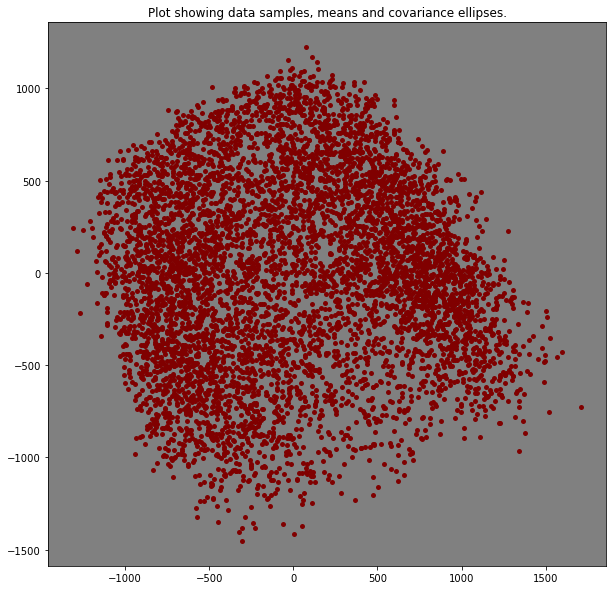

In [67]:
fig = plt.figure(figsize=(10,10))
ax=plt.gca() # Get current axis
ax.set_title('Plot showing data samples, means and covariance ellipses.')
ax.set_facecolor('gray')

plt.scatter(P_train[:, 0], P_train[:, 1], s=25, linewidths=0, facecolors=col, marker="o")

dark_colors = [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]]
for μ, S, col in zip([μ0, μ1, μ2, μ3, μ4, μ5, μ6, μ7, μ8, μ9], [S0, S1, S2, S3, S4, S5, S6, S7, S8, S9], dark_colors):
    e = draw_ellipse(μ, S, edgecolor=col, linewidth=2, facecolor='none')
    s = plt.scatter(μ[0], μ[1], s=100, linewidth=0, facecolor=col, marker="X")

    ax.add_artist(e)
    ax.add_artist(s)

plt.show()

## Outliers

In [22]:
Log_Probs = estimator.score_samples(P_train)

In [23]:
outlierly_sorted = np.argsort(Log_Probs)

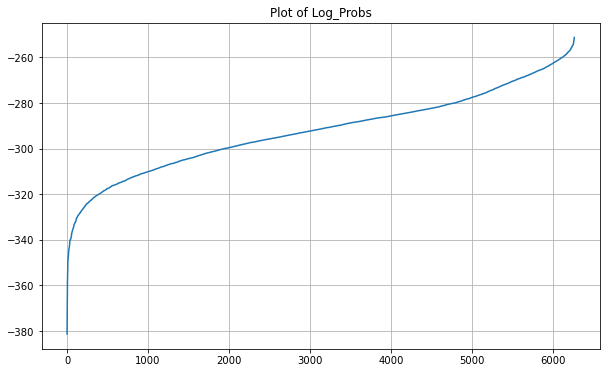

In [24]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(Log_Probs)), np.sort(Log_Probs))
plt.title('Plot of Log_Probs')
plt.grid(True)
plt.show()

In [25]:
Poutl = P_train[outlierly_sorted[:10]]

In [26]:
Poutl.shape

(10, 50)

In [27]:
Xoutl = pca.inv_transform(Poutl)

In [28]:
Xoutl.shape

(10, 784)

## Writing data to Excel

In [35]:
Means = [μ0, μ1, μ2, μ3, μ4, μ5, μ6, μ7, μ8, μ9, μ10]

In [36]:
Weights = [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]

In [37]:
Outliers = Xoutl

In [38]:
excelfile=r"C:\Users\ronte\Google Drive\Berkeley\01 Introduction to Machine Learning Using Python\Assignment 5\Assignment_5_Submission_Template.xlsx";

In [39]:
writeExcelData(Means,excelfile,'Results',2,2)
writeExcelData(Weights,excelfile,'Results',14,2)
writeExcelData(Outliers,excelfile,'Results',26,2)

print("Written mean values, Means, Weights, and Outliers")

Written mean values, Means, Weights, and Outliers
